# Chapter 10

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Review

So far we have been working with distributions of only one variable.  In this notebook we'll take a step toward multivariate distributions, starting with two variables.

We'll use cross-tabulation to compute a **joint distribution**, then use the joint distribution to compute **conditional distributions** and **marginal distributions**.

We will re-use `pmf_from_seq`, which I introduced in a previous notebook.

In [2]:
def pmf_from_seq(seq):
    """Make a PMF from a sequence of values.
    
    seq: sequence
    
    returns: Series representing a PMF
    """
    pmf = pd.Series(seq).value_counts(sort=False).sort_index()
    pmf /= pmf.sum()
    return pmf

## Cross tabulation

To understand joint distributions, I'll start with cross tabulation.  And to demonstrate cross tabulation, I'll generate a dataset of colors and fruits.

Here are the possible values.

In [3]:
colors = ['red', 'yellow', 'green']
fruits = ['apple', 'banana', 'grape']

And here's a random sample of 100 fruits.

In [4]:
np.random.seed(2)
fruit_sample = np.random.choice(fruits, 100, replace=True)

We can use `pmf_from_seq` to compute the distribution of fruits.

In [5]:
pmf_fruit = pmf_from_seq(fruit_sample)
pmf_fruit

apple     0.32
banana    0.29
grape     0.39
dtype: float64

And here's what it looks like.

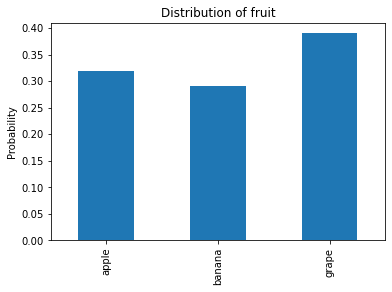

In [6]:
pmf_fruit.plot.bar(color='C0')

plt.ylabel('Probability')
plt.title('Distribution of fruit');

Similarly, here's a random sample of colors.

In [7]:
color_sample = np.random.choice(colors, 100, replace=True)

Here's the distribution of colors.

In [8]:
pmf_color = pmf_from_seq(color_sample)
pmf_color

green     0.32
red       0.33
yellow    0.35
dtype: float64

And here's what it looks like.

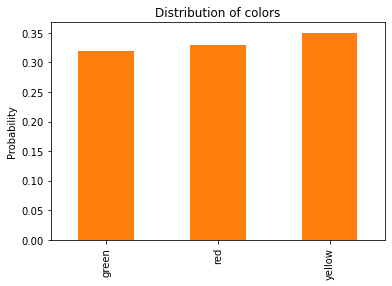

In [9]:
pmf_color.plot.bar(color='C1')

plt.ylabel('Probability')
plt.title('Distribution of colors');

Looking at these distributions, we know the proportion of each fruit, ignoring color, and we know the proportion of each color, ignoring fruit type.

But if we only have the distributions and not the original data, we don't know how many apples are green, for example, or how many yellow fruits are bananas.

We can compute that information using `crosstab`, which computes the number of cases for each combination of fruit type and color.

In [10]:
xtab = pd.crosstab(color_sample, fruit_sample, 
                   rownames=['color'], colnames=['fruit'])
xtab

fruit,apple,banana,grape
color,,,
green,11,9,12
red,12,8,13
yellow,9,12,14


The result is a DataFrame with colors along the rows and fruits along the columns.

## Heatmap

The following function plots a cross tabulation using a pseudo-color plot, also known as a heatmap.

It represents each element of the cross tabulation with a colored square, where the color corresponds to the magnitude of the element.

The following function generates a heatmap using the Matplotlib function `pcolormesh`:

In [11]:
def plot_heatmap(xtab):
    """Make a heatmap to represent a cross tabulation.
    
    xtab: DataFrame containing a cross tabulation
    """

    plt.pcolormesh(xtab)

    # label the y axis
    ys = xtab.index
    plt.ylabel(ys.name)
    locs = np.arange(len(ys)) + 0.5
    plt.yticks(locs, ys)

    # label the x axis
    xs = xtab.columns
    plt.xlabel(xs.name)
    locs = np.arange(len(xs)) + 0.5
    plt.xticks(locs, xs)
    
    plt.colorbar()
    plt.gca().invert_yaxis()

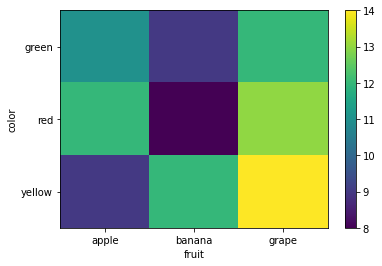

In [12]:
plot_heatmap(xtab)

## Joint Distribution

A cross tabulation represents the "joint distribution" of two variables, which is a complete description of two distributions, including all of the conditional distributions.

If we normalize `xtab` so the sum of the elements is 1, the result is a joint PMF:

In [13]:
joint = xtab / xtab.to_numpy().sum()
joint

fruit,apple,banana,grape
color,,,
green,0.11,0.09,0.12
red,0.12,0.08,0.13
yellow,0.09,0.12,0.14


Each column in the joint PMF represents the conditional distribution of color for a given fruit.

For example, we can select a column like this:

In [14]:
col = joint['apple']
col

color
green     0.11
red       0.12
yellow    0.09
Name: apple, dtype: float64

If we normalize it, we get the conditional distribution of color for a given fruit.

In [15]:
col / col.sum()

color
green     0.34375
red       0.37500
yellow    0.28125
Name: apple, dtype: float64

Each row of the cross tabulation represents the conditional distribution of fruit for each color.

If we select a row and normalize it, like this:

In [16]:
row = xtab.loc['red']
row / row.sum()

fruit
apple     0.363636
banana    0.242424
grape     0.393939
Name: red, dtype: float64

The result is the conditional distribution of fruit type for a given color.

## Conditional distributions

The following function takes a joint PMF and computes conditional distributions:

In [17]:
def conditional(joint, name, value):
    """Compute a conditional distribution.
    
    joint: DataFrame representing a joint PMF
    name: string name of an axis
    value: value to condition on
    
    returns: Series representing a conditional PMF
    """
    if joint.columns.name == name:
        cond = joint[value]
    elif joint.index.name == name:
        cond = joint.loc[value]
    return cond / cond.sum()

The second argument is a string that identifies which axis we want to select; in this example, `'fruit'` means we are selecting a column, like this:

In [18]:
conditional(joint, 'fruit', 'apple')

color
green     0.34375
red       0.37500
yellow    0.28125
Name: apple, dtype: float64

And `'color'` means we are selecting a row, like this:

In [19]:
conditional(joint, 'color', 'red')

fruit
apple     0.363636
banana    0.242424
grape     0.393939
Name: red, dtype: float64

**Exercise:** Compute the conditional distribution of color for bananas.  What is the probability that a banana is yellow?

In [20]:
# Solution goes here

In [21]:
# Solution goes here

## Marginal distributions

Given a joint distribution, we can compute the unconditioned distribution of either variable.

If we sum along the rows, which is axis 0, we get the distribution of fruit type, regardless of color.

In [22]:
joint.sum(axis=0)

fruit
apple     0.32
banana    0.29
grape     0.39
dtype: float64

If we sum along the columns, which is axis 1, we get the distribution of color, regardless of fruit type.

In [23]:
joint.sum(axis=1)

color
green     0.32
red       0.33
yellow    0.35
dtype: float64

These distributions are called "[marginal](https://en.wikipedia.org/wiki/Marginal_distribution#Multivariate_distributions)" because of the way they are often displayed.  We'll see an example later.

As we did with conditional distributions, we can write a function that takes a joint distribution and computes the marginal distribution of a given variable:

In [24]:
def marginal(joint, name):
    """Compute a marginal distribution.
    
    joint: DataFrame representing a joint PMF
    name: string name of an axis
    
    returns: Series representing a marginal PMF
    """
    if joint.columns.name == name:
        return joint.sum(axis=0)
    elif joint.index.name == name:
        return joint.sum(axis=1)

Here's the marginal distribution of fruit.

In [25]:
pmf_fruit = marginal(joint, 'fruit')
pmf_fruit

fruit
apple     0.32
banana    0.29
grape     0.39
dtype: float64

And the marginal distribution of color:

In [26]:
pmf_color = marginal(joint, 'color')
pmf_color

color
green     0.32
red       0.33
yellow    0.35
dtype: float64

The sum of the marginal PMF is the same as the sum of the joint PMF, so if the joint PMF was normalized, the marginal PMF should be, too.

In [27]:
joint.to_numpy().sum()

1.0

In [28]:
pmf_color.sum()

1.0

However, due to floating point error, the total might not be exactly 1.

In [29]:
pmf_fruit.sum()

0.9999999999999999

**Exercise:** The following cells load the data from the General Social Survey that we used in Notebooks 1 and 2.

In [30]:
# Load the data file
import os

if not os.path.exists('gss_bayes.csv'):
    !wget https://github.com/AllenDowney/BiteSizeBayes/raw/master/gss_bayes.csv

In [31]:
gss = pd.read_csv('gss_bayes.csv', index_col=0)

As an exercise, you can use this data to explore the joint distribution of two variables:

* `partyid` encodes each respondent's political affiliation, that is, the party the belong to.  [Here's the description](https://gssdataexplorer.norc.org/variables/141/vshow).

* `polviews` encodes their political alignment on a spectrum from liberal to conservative.  [Here's the description](https://gssdataexplorer.norc.org/variables/178/vshow).

The values for `partyid` are

```
0	Strong democrat
1	Not str democrat
2	Ind,near dem
3	Independent
4	Ind,near rep
5	Not str republican
6	Strong republican
7	Other party
```

The values for `polviews` are:

```
1	Extremely liberal
2	Liberal
3	Slightly liberal
4	Moderate
5	Slightly conservative
6	Conservative
7	Extremely conservative
```

Make a cross tabulation of `gss['partyid']` and `gss['polviews']` and normalize it to make a joint PMF.


In [32]:
# Solution goes here

Use `plot_heatmap` to display a heatmap of the joint distribution.  What patterns do you notice?

In [33]:
plot_heatmap(joint2)

plt.xlabel('polviews')
plt.title('Joint distribution of polviews and partyid');

NameError: name 'joint2' is not defined

Use `marginal` to compute the marginal distributions of `partyid` and `polviews`, and plot the results.

In [34]:
# Solution goes here

In [35]:
# Solution goes here

Use `conditional` to compute the conditional distribution of `partyid` for people who identify themselves as "Extremely conservative" (`polviews==7`).  How many of them are "strong Republicans" (`partyid==6`)?

In [36]:
# Solution goes here

Use `conditional` to compute the conditional distribution of `polviews` for people who identify themselves as "Strong Democrat" (`partyid==0`).  How many of them are "Extremely liberal" (`polviews==1`)?

In [37]:
# Solution goes here

## Review

In this notebook we started with cross tabulation, which we normalized to create a joint distribution, which describes the distribution of two (or more) variables and all of their conditional distributions.

We used heatmaps to visualize cross tabulations and joint distributions.

Then we defined `conditional` and `marginal` functions that take a joint distribution and compute conditional and marginal distributions for each variables.

As an exercise, you had a chance to apply the same methods to explore the relationship between political alignment and party affiliation using data from the General Social Survey.

You might have noticed that we did not use Bayes's Theorem in this notebook.  [In the next notebook](https://colab.research.google.com/github/AllenDowney/BiteSizeBayes/blob/master/11_faceoff.ipynb) we'll take the ideas from this notebook and apply them Bayesian inference.